# Specifying and estimating a linkage model

We've just seen how to use Splink's exploratory analysis tools to understand our data.  

Now it's time to build a linkage model.  This model will make pairwise comparisons of input records and output a match score, which is a prediction of whether the two records represent the same entity (e.g. are the same person).  You can read more about the theory behind probabilistic linkage models [here](https://www.robinlinacre.com/intro_to_probabilistic_linkage/).




In [1]:
# Begin by reading in the tutorial data again
from splink.duckdb.duckdb_linker import DuckDBLinker
import pandas as pd 
import altair as alt
alt.renderers.enable("mimetype")
df = pd.read_csv("./data/fake_1000.csv")

##  Specifying a linkage model

To produce a match score, `splink` needs to know how to compare the information in pairs records from the input dataset.

To be concrete, here is an example pairwise record comparison from our input dataset:


|   unique_id | first_name   | surname   | dob        | city   | email               |
|------------:|:-------------|:----------|:-----------|:-------|:--------------------|
|           1 | Robert       | Allen     | 1971-05-24 | nan    | roberta25@smith.net |
|           2 | Rob          | Allen     | 1971-06-24 | London | roberta25@smith.net |

What functions should we use to assess the similarity of `Rob` vs. `Robert` in the the `first_name` field?  Should similarity in the `dob` field be computed in the same way, or a different way?

Your job as the developer of a linkage model is to decide what comparisons are most appropriate for the types of data you have.  

### Comparisons

The concept of a `Comparison` has a specific definition within Splink: it defines how data from one or more input columns is compared, using SQL expressions assess similarity.

For example, one `Comparison` may represent how similarity is assessed for a person's date of birth. Another `Comparison` may represent the comparison of a person's name or location.

A model will thereby be composed of many `Comparison`s, which between them assess the similarity of all of the columns being used for data linking.  

Each `Comparison` contains two or more `ComparisonLevels` which define _n_ discrete gradations of similarity between the input columns within the Comparison.

For example, for the date of birth `Comparison` there may be a `ComparisonLevel` for an exact match, another for a one-character difference, and another for all other comparisons.

To summarise:

```
Data Linking Model
├─-- Comparison: Date of birth
│    ├─-- ComparisonLevel: Exact match
│    ├─-- ComparisonLevel: One character difference
│    ├─-- ComparisonLevel: All other
├─-- Comparison: City
│    ├─-- ComparisonLevel: Exact match on city
│    ├─-- ComparisonLevel: All other
│    etc.
```

More information about comparisons can be found [here](https://moj-analytical-services.github.io/splink/comparison.html).


We will now use these concepts to build a data linking model

### Specifying the model using comparisons

Splink provides utility functions to help formulate some of the most common comparison types, which we'll make use of in this introductory example.

Let's start by looking at a single comparison:

In [2]:
import splink.duckdb.duckdb_comparison_library as cl

first_name_comparison = cl.levenshtein_at_thresholds("first_name", 2)
print(first_name_comparison.human_readable_description)


Comparison 'Exact match vs. levenshtein at threshold 2 vs. anything else' of first_name.
Similarity is assessed using the following ComparisonLevels:
    - 'Null' with SQL rule: first_name_l IS NULL OR first_name_r IS NULL
    - 'Exact match' with SQL rule: first_name_l = first_name_r
    - 'levenshtein <= 2' with SQL rule: levenshtein(first_name_l, first_name_r) <= 2
    - 'All other comparisons' with SQL rule: ELSE



## Specifying the full settings dictionary

`Comparisons` are specified as part of the Splink `settings`, a Python dictionary which controls all of the configuration of a Splink model.

Let's take a look at a full settings dictionary:

In [3]:
settings = {
    "probability_two_random_records_match": 4/1000,
    "link_type": "dedupe_only",
    "comparisons": [
        cl.levenshtein_at_thresholds("first_name", 2),
        cl.levenshtein_at_thresholds("surname"),
        cl.levenshtein_at_thresholds("dob"),
        cl.exact_match("city", term_frequency_adjustments=True),
        cl.levenshtein_at_thresholds("email"),
    ],
    "blocking_rules_to_generate_predictions": [
        "l.first_name = r.first_name",
        "l.surname = r.surname",
    ],
    "retain_matching_columns": True,
    "retain_intermediate_calculation_columns": True,
    "additional_columns_to_retain": ["cluster"],
}

In words, this setting dictionary says:

* We have set a starting value for `probability_two_random_records_match` to 4/1000.  This is a starting value - we will later estimate this parameter
* We are performing a `dedupe_only` (the other options are `link_only`, or `link_and_dedupe`, which may be used if there are multiple input datasets)
* When comparing records, we will use information from the `first_name`, `surname`, `dob`, `city` and `email` columns to compute a match score.
* The `blocking_rules_to_generate_predictions` states that we will only check for duplicates amongst records where either the `first_name` or `surname` is identical.
* We have enabled term frequency adjustments for the 'city' column, because some values (e.g. `London`) appear much more frequently than others
* We will retain the `cluster` column in the results even though this is not used as part of comparisons. Later we'll be able to use this to compare Splink scores to the ground truth.
* We have set `retain_intermediate_calculation_columns` and `additional_columns_to_retain` to `True`  so that Splink outputs additional information that helps the user understand the calculations. If they were `False`, the computations would run faster.

## Estimate the parameters of the model

Now that we have specified our linkage model, we want to estimate its `m` and `u` parameters. 

- The `m` values are the proportion of records falling into each `ComparisonLevel` amongst truly *matching* records

- The `u` values are the proportion of records falling into each `ComparisonLevel` amongst truly *non-matching* records

You can read more about the theory of what these mean [here](https://www.robinlinacre.com/maths_of_fellegi_sunter/).

We begin by using `estimate_u_using_random_sampling` method to compute the `u` values of the model.  This is a simple direct estimation algorithm.  The larger the random sample, the more accurate the predictions.  You control this using the `target_rows` parameter. For large datasets, we recommend using at least 10 million - but the higher the better and 1 billion is often appropriate for larger datasets.

In [4]:
linker = DuckDBLinker(df, settings)
linker.estimate_u_using_random_sampling(target_rows=1e6)

----- Estimating u probabilities using random sampling -----

Estimated u probabilities using random sampling

Your model is not yet fully trained. Missing estimates for:
    - first_name (no m values are trained).
    - surname (no m values are trained).
    - dob (no m values are trained).
    - city (no m values are trained).
    - email (no m values are trained).


We then use the expectation maximisation algorithm to train the `m` values.

This algorithm estimates the `m` values by generating pairwise record comparisons, and using them to maximise a likelihood function. 

Each estimation pass requires the user to configure an estimation blocking rule to reduce the number of record comparisons generated to a managable level.


In our first estimation pass, we block on `first_name` and `surname`, meaning we will generate all record comparisons that have `first_name` and `surname` exactly equal.   

Recall we are trying to estimate the `m` values of the model, i.e. proportion of records falling into each `ComparisonLevel` amongst truly matching records.

This means that, in this training session, we cannot estimate parameter estimates for the `first_name` or `surname` columns, since we have forced them to be equal 100% of the time.

We can, however, estimate parameter estimates for all of the other columns.  The output messages produced by Splink confirm this.

In [5]:
training_blocking_rule = "l.first_name = r.first_name and l.surname = r.surname"
training_session_fname_sname = linker.estimate_parameters_using_expectation_maximisation(training_blocking_rule)


----- Starting EM training session -----

Estimating the m probabilities of the model by blocking on:
l.first_name = r.first_name and l.surname = r.surname

Parameter estimates will be made for the following comparison(s):
    - dob
    - city
    - email

Parameter estimates cannot be made for the following comparison(s) since they are used in the blocking rules: 
    - first_name
    - surname

Iteration 1: Largest change in params was -0.531 in the m_probability of dob, level `Exact match`
Iteration 2: Largest change in params was 0.0331 in probability_two_random_records_match
Iteration 3: Largest change in params was 0.0128 in probability_two_random_records_match
Iteration 4: Largest change in params was 0.00635 in probability_two_random_records_match
Iteration 5: Largest change in params was 0.00363 in probability_two_random_records_match
Iteration 6: Largest change in params was 0.00225 in probability_two_random_records_match
Iteration 7: Largest change in params was 0.00146 in 

In a second estimation pass, we block on dob. This allows us to estimate parameters for the `first_name` and `surname` comparisons.

Between the two estimation passes, we now have parameter estimates for all comparisons.

In [6]:
training_blocking_rule = "l.dob = r.dob"
training_session_dob = linker.estimate_parameters_using_expectation_maximisation(training_blocking_rule)


----- Starting EM training session -----

Estimating the m probabilities of the model by blocking on:
l.dob = r.dob

Parameter estimates will be made for the following comparison(s):
    - first_name
    - surname
    - city
    - email

Parameter estimates cannot be made for the following comparison(s) since they are used in the blocking rules: 
    - dob

Iteration 1: Largest change in params was 0.48 in probability_two_random_records_match
Iteration 2: Largest change in params was 0.151 in probability_two_random_records_match
Iteration 3: Largest change in params was 0.0477 in probability_two_random_records_match
Iteration 4: Largest change in params was 0.0177 in probability_two_random_records_match
Iteration 5: Largest change in params was 0.00797 in probability_two_random_records_match
Iteration 6: Largest change in params was 0.004 in probability_two_random_records_match
Iteration 7: Largest change in params was 0.00213 in probability_two_random_records_match
Iteration 8: Large

Note that Splink includes other algorithms for estimating m and u values, which are documented [here](https://moj-analytical-services.github.io/splink/linkerest.html).

## Visualising model parameters

Splink can generate a number of charts to help you understand your model.  For an introduction to these charts and how to interpret them, please see [this](https://www.youtube.com/watch?v=msz3T741KQI&t=507s) video.

The final estimated match weights can be viewed in the match weights chart:

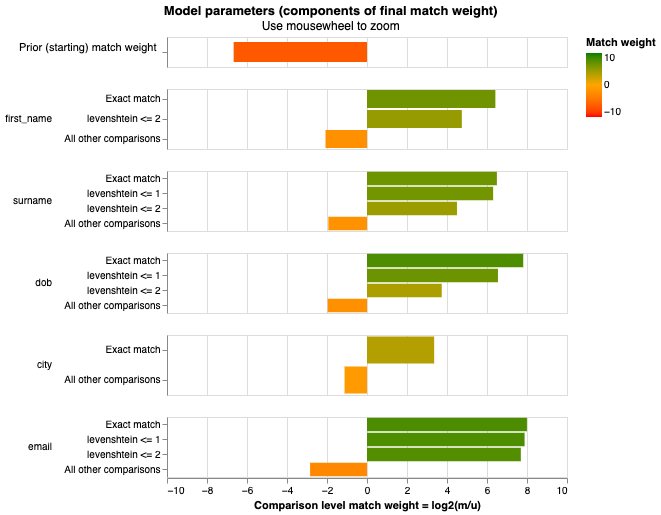

In [7]:
linker.match_weights_chart()

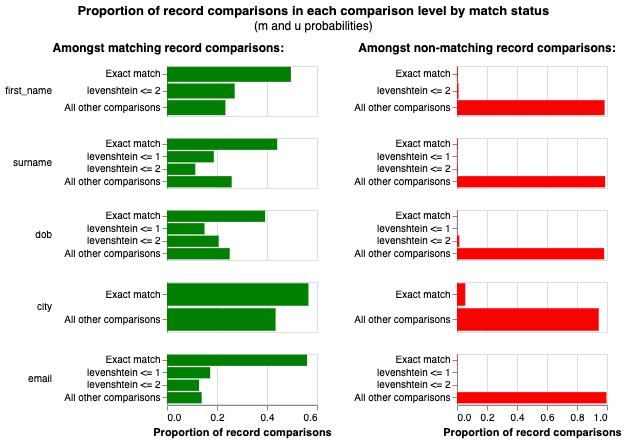

In [8]:
linker.m_u_parameters_chart()

### Saving the model

Finally we can save the model, including our estimated parameters, to a `.json` file, so we can use it in the next tutorial.

In [9]:
linker.save_settings_to_json("./demo_settings/saved_model_from_demo.json", overwrite=True)

## Next steps

Now we have trained a model, we can move on to using it predict matching records


## Further reading

Full documentation for all of the ways of estimating model parameters can be found [here](https://moj-analytical-services.github.io/splink/linkerest.html).